In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
objects = [i for i in range(1,11)]

In [4]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

feature_extractor = torch.nn.Sequential(*list(alexnet.features.children())[:7])
feature_extractor.eval()

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = feature_extractor(image)
    feature_vector = features.view(-1).numpy()
    feature_vector /= np.linalg.norm(feature_vector)
    return feature_vector


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 168MB/s]


In [6]:
np.random.seed(42)
original_dim = 64896
projected_dim = 8192
R = np.random.randn(projected_dim, original_dim)
R /= np.linalg.norm(R, axis=1, keepdims=True)
def project_features(feature_vector):
    projected_vector = R @ feature_vector
    projected_vector = np.clip(projected_vector, -1, 1)
    return projected_vector


In [7]:
x_angle = 0
y_angles = list(range(0, 360, 5))
z_angles = [(x_angle + y) // 2 for y in y_angles]
z_angles = [z if z % 5 == 0 and z <= 355 else None for z in z_angles]

In [8]:
I_k_x = {}
I_k_y = {}
I_k_z = {}
I_k_bundle = {}
I_k_B4 = {}
I_k_B8 = {}

# Angles for B4 and B8
B4_angles = [0, 90, 180, 270]
B8_angles = [0, 45, 90, 135, 180, 225, 270, 315]

# Precompute position-independent vectors for B4 and B8
for k in objects:
    I_k_B4[k] = np.zeros(projected_dim)
    I_k_B8[k] = np.zeros(projected_dim)
    for angle in B4_angles:
        image_path = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{angle}.png'
        feature_vector = extract_features(image_path)
        projected_vector = project_features(feature_vector)
        I_k_B4[k] += projected_vector
    for angle in B8_angles:
        image_path = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{angle}.png'
        feature_vector = extract_features(image_path)
        projected_vector = project_features(feature_vector)
        I_k_B8[k] += projected_vector


In [9]:
mean_distances_individual = []
mean_distances_bundle = []
mean_distances_B4 = []
mean_distances_B8 = []
angular_distances = []

for y_angle, z_angle in zip(y_angles, z_angles):
    if z_angle is None:
        continue
    angular_distance = (y_angle - x_angle) / 2
    angular_distances.append(angular_distance)

    distances_individual = []
    distances_bundle = []
    distances_B4 = []
    distances_B8 = []

    for k in objects:
        if (k, x_angle) not in I_k_x:
            image_path_x = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{x_angle}.png'
            feature_vector_x = extract_features(image_path_x)
            projected_vector_x = project_features(feature_vector_x)
            I_k_x[(k, x_angle)] = projected_vector_x
        else:
            projected_vector_x = I_k_x[(k, x_angle)]

        if (k, y_angle) not in I_k_y:
            image_path_y = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{y_angle}.png'
            feature_vector_y = extract_features(image_path_y)
            projected_vector_y = project_features(feature_vector_y)
            I_k_y[(k, y_angle)] = projected_vector_y
        else:
            projected_vector_y = I_k_y[(k, y_angle)]

        I_k_bundle[k] = projected_vector_x + projected_vector_y

        image_path_z = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{z_angle}.png'
        feature_vector_z = extract_features(image_path_z)
        projected_vector_z = project_features(feature_vector_z)
        I_k_z[k] = projected_vector_z

        d_x = 1 - np.dot(projected_vector_z, projected_vector_x) / (np.linalg.norm(projected_vector_z) * np.linalg.norm(projected_vector_x))
        d_y = 1 - np.dot(projected_vector_z, projected_vector_y) / (np.linalg.norm(projected_vector_z) * np.linalg.norm(projected_vector_y))
        d_individual = min(d_x, d_y)
        distances_individual.append(d_individual)

        bundle_vector = I_k_bundle[k]
        d_bundle = 1 - np.dot(projected_vector_z, bundle_vector) / (np.linalg.norm(projected_vector_z) * np.linalg.norm(bundle_vector))
        distances_bundle.append(d_bundle)

        B4_vector = I_k_B4[k]
        d_B4 = 1 - np.dot(projected_vector_z, B4_vector) / (np.linalg.norm(projected_vector_z) * np.linalg.norm(B4_vector))
        distances_B4.append(d_B4)

        B8_vector = I_k_B8[k]
        d_B8 = 1 - np.dot(projected_vector_z, B8_vector) / (np.linalg.norm(projected_vector_z) * np.linalg.norm(B8_vector))
        distances_B8.append(d_B8)

    mean_distances_individual.append(np.mean(distances_individual))
    mean_distances_bundle.append(np.mean(distances_bundle))
    mean_distances_B4.append(np.mean(distances_B4))
    mean_distances_B8.append(np.mean(distances_B8))


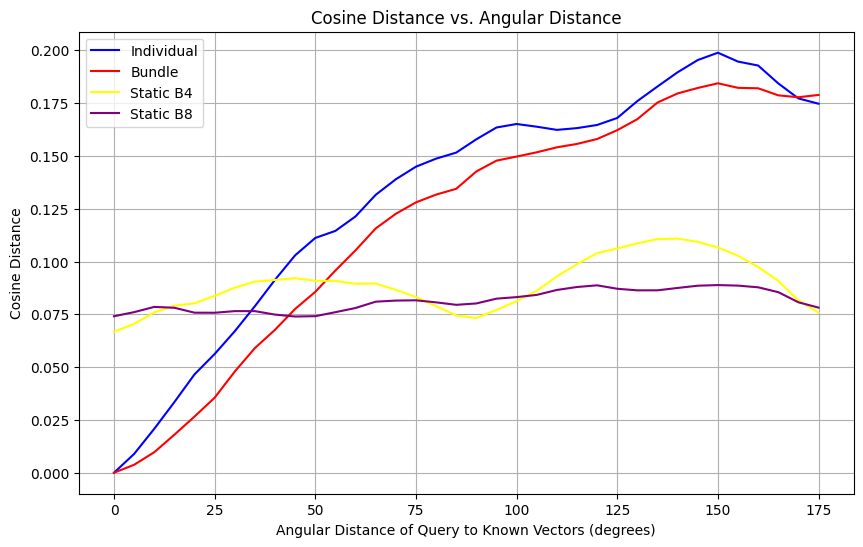

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(angular_distances, mean_distances_individual, label='Individual', color='blue')
plt.plot(angular_distances, mean_distances_bundle, label='Bundle', color='red')
plt.plot(angular_distances, mean_distances_B4, label='Static B4', color='yellow')
plt.plot(angular_distances, mean_distances_B8, label='Static B8', color='purple')
plt.xlabel('Angular Distance of Query to Known Vectors (degrees)')
plt.ylabel('Cosine Distance')
plt.title('Cosine Distance vs. Angular Distance')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Precomputing B4 and B8 bundles...


100%|██████████| 50/50 [04:12<00:00,  5.05s/it]


Precomputing I_k_x...


100%|██████████| 50/50 [00:00<00:00, 89.09it/s] 


Starting main loop over angles...


100%|██████████| 72/72 [25:20<00:00, 21.12s/it]


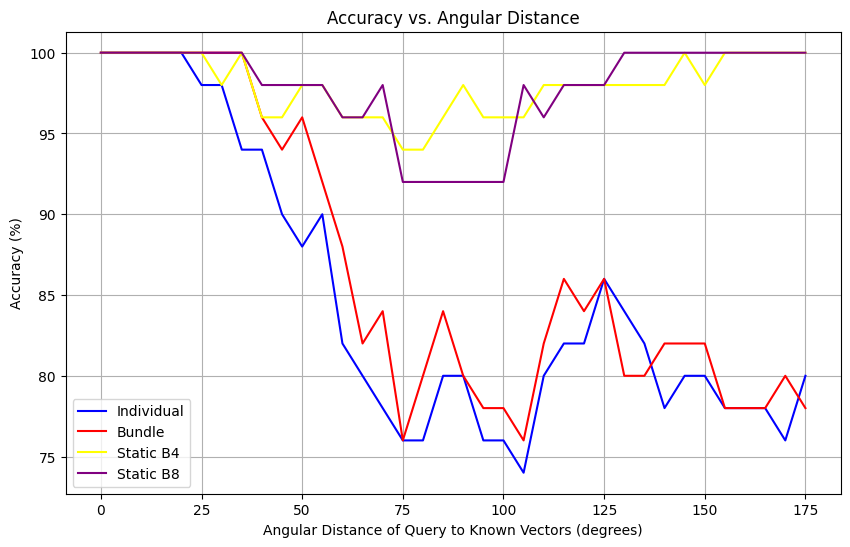

In [13]:


transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

np.random.seed(42)
torch.manual_seed(42)

original_dim = 64896
projected_dim = 8192

R = torch.randn(projected_dim, original_dim, device=device)
R = R / R.norm(dim=1, keepdim=True)

x_angle = 0
y_angles = list(range(0, 360, 5))

z_angles = [(x_angle + y) // 2 for y in y_angles]

objects = list(range(1, 51))

I_k_x = {}
I_k_y = {}
I_k_z = {}
I_k_bundle = {}
I_k_B4 = {}
I_k_B8 = {}

alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()

feature_extractor = torch.nn.Sequential(*list(alexnet.features.children())[:7]).to(device)
feature_extractor.eval()

def extract_features_batch(image_paths):
    images = []
    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)
    images = torch.stack(images).to(device)
    with torch.no_grad():
        features = feature_extractor(images)
    feature_vectors = features.view(features.size(0), -1)
    feature_vectors = feature_vectors / feature_vectors.norm(dim=1, keepdim=True)
    return feature_vectors

def project_features_batch(feature_vectors):
    projected_vectors = torch.matmul(feature_vectors, R.t())
    projected_vectors = torch.clamp(projected_vectors, -1, 1)
    return projected_vectors

B4_angles = [0, 90, 180, 270]
B8_angles = [0, 45, 90, 135, 180, 225, 270, 315]

print("Precomputing B4 and B8 bundles...")
for k in tqdm(objects):
    image_paths_B4 = [f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{angle}.png' for angle in B4_angles]
    feature_vectors_B4 = extract_features_batch(image_paths_B4)
    projected_vectors_B4 = project_features_batch(feature_vectors_B4)
    I_k_B4[k] = projected_vectors_B4.sum(dim=0)
    image_paths_B8 = [f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{angle}.png' for angle in B8_angles]
    feature_vectors_B8 = extract_features_batch(image_paths_B8)
    projected_vectors_B8 = project_features_batch(feature_vectors_B8)
    I_k_B8[k] = projected_vectors_B8.sum(dim=0)
print("Precomputing I_k_x...")
for k in tqdm(objects):
    image_path_x = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{angle}.png'
    feature_vector_x = extract_features_batch([image_path_x])
    projected_vector_x = project_features_batch(feature_vector_x)[0]
    I_k_x[(k, x_angle)] = projected_vector_x

accuracies_individual = []
accuracies_bundle = []
accuracies_B4 = []
accuracies_B8 = []
angular_distances = []

print("Starting main loop over angles...")
for y_angle, z_angle in tqdm(zip(y_angles, z_angles), total=len(y_angles)):
    if z_angle % 5 != 0 or z_angle > 355:
        continue
    angular_distance = (y_angle - x_angle) / 2
    angular_distances.append(angular_distance)
    bundle_vectors = []
    bundle_labels = []
    individual_vectors = []
    individual_labels = []
    query_vectors = []
    query_labels = []
    B4_vectors = []
    B4_labels = []
    B8_vectors = []
    B8_labels = []
    image_paths_y = []
    indices_y = []
    image_paths_z = []
    indices_z = []

    for k in objects:
        if (k, y_angle) not in I_k_y:
            image_path_y = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{y_angle}.png'
            image_paths_y.append(image_path_y)
            indices_y.append((k, y_angle))
        else:
            projected_vector_y = I_k_y[(k, y_angle)]

        if k not in I_k_z or z_angle not in I_k_z[k]:
            image_path_z = f'/content/drive/MyDrive/aloi_small/aloi_small/{k}/{k}_r{z_angle}.png'
            image_paths_z.append(image_path_z)
            indices_z.append((k, z_angle))
        else:
            projected_vector_z = I_k_z[k][z_angle]

    if image_paths_y:
        feature_vectors_y = extract_features_batch(image_paths_y)
        projected_vectors_y = project_features_batch(feature_vectors_y)
        for idx, projected_vector_y in zip(indices_y, projected_vectors_y):
            I_k_y[idx] = projected_vector_y

    if image_paths_z:
        feature_vectors_z = extract_features_batch(image_paths_z)
        projected_vectors_z = project_features_batch(feature_vectors_z)
        for idx, projected_vector_z in zip(indices_z, projected_vectors_z):
            k_z, z_ang = idx
            if k_z not in I_k_z:
                I_k_z[k_z] = {}
            I_k_z[k_z][z_ang] = projected_vector_z

    for k in objects:
        projected_vector_x = I_k_x[(k, x_angle)]
        projected_vector_y = I_k_y[(k, y_angle)]
        projected_vector_z = I_k_z[k][z_angle]

        bundle_vector = projected_vector_x + projected_vector_y
        I_k_bundle[(k, y_angle)] = bundle_vector

        bundle_vectors.append(bundle_vector)
        bundle_labels.append(k)

        individual_vectors.extend([projected_vector_x, projected_vector_y])
        individual_labels.extend([k, k])

        B4_vectors.append(I_k_B4[k])
        B4_labels.append(k)
        B8_vectors.append(I_k_B8[k])
        B8_labels.append(k)

        query_vectors.append(projected_vector_z)
        query_labels.append(k)

    bundle_vectors = torch.stack(bundle_vectors).to(device)
    bundle_labels = torch.tensor(bundle_labels).to(device)
    individual_vectors = torch.stack(individual_vectors).to(device)
    individual_labels = torch.tensor(individual_labels).to(device)
    query_vectors = torch.stack(query_vectors).to(device)
    query_labels = torch.tensor(query_labels).to(device)
    B4_vectors = torch.stack(B4_vectors).to(device)
    B4_labels = torch.tensor(B4_labels).to(device)
    B8_vectors = torch.stack(B8_vectors).to(device)
    B8_labels = torch.tensor(B8_labels).to(device)

    with torch.no_grad():
        cos_sim_bundle = torch.nn.functional.cosine_similarity(
            query_vectors.unsqueeze(1),
            bundle_vectors.unsqueeze(0),
            dim=2
        )
        _, indices_bundle = cos_sim_bundle.max(dim=1)
        predicted_labels_bundle = bundle_labels[indices_bundle]
        correct_bundle = (predicted_labels_bundle == query_labels)
        accuracy_bundle = correct_bundle.float().mean().item() * 100
        accuracies_bundle.append(accuracy_bundle)

        cos_sim_individual = torch.nn.functional.cosine_similarity(
            query_vectors.unsqueeze(1),
            individual_vectors.unsqueeze(0),
            dim=2
        )
        _, indices_individual = cos_sim_individual.max(dim=1)
        predicted_labels_individual = individual_labels[indices_individual]
        correct_individual = (predicted_labels_individual == query_labels)
        accuracy_individual = correct_individual.float().mean().item() * 100
        accuracies_individual.append(accuracy_individual)

        cos_sim_B4 = torch.nn.functional.cosine_similarity(
            query_vectors.unsqueeze(1),
            B4_vectors.unsqueeze(0),
            dim=2
        )
        _, indices_B4 = cos_sim_B4.max(dim=1)
        predicted_labels_B4 = B4_labels[indices_B4]
        correct_B4 = (predicted_labels_B4 == query_labels)
        accuracy_B4 = correct_B4.float().mean().item() * 100
        accuracies_B4.append(accuracy_B4)

        cos_sim_B8 = torch.nn.functional.cosine_similarity(
            query_vectors.unsqueeze(1),
            B8_vectors.unsqueeze(0),
            dim=2
        )
        _, indices_B8 = cos_sim_B8.max(dim=1)
        predicted_labels_B8 = B8_labels[indices_B8]
        correct_B8 = (predicted_labels_B8 == query_labels)
        accuracy_B8 = correct_B8.float().mean().item() * 100
        accuracies_B8.append(accuracy_B8)

plt.figure(figsize=(10, 6))
plt.plot(angular_distances, accuracies_individual, label='Individual', color='blue')
plt.plot(angular_distances, accuracies_bundle, label='Bundle', color='red')
plt.plot(angular_distances, accuracies_B4, label='Static B4', color='yellow')
plt.plot(angular_distances, accuracies_B8, label='Static B8', color='purple')
plt.xlabel('Angular Distance of Query to Known Vectors (degrees)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Angular Distance')
plt.legend()
plt.grid(True)
plt.show()
